In [1]:
import numpy as np
import pandas as pd
import scipy.optimize as optimize
from datetime import datetime
from numpy.linalg import eig
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta

In [3]:
df_raw = pd.read_excel("/content/data.xlsx")
df_raw.head()

,ISIN,Issue Date,Maturity Date,Coupon,2024-01-08 00:00:00,2024-01-09 00:00:00,2024-01-10 00:00:00,2024-01-11 00:00:00,2024-01-12 00:00:00,2024-01-15 00:00:00,2024-01-16 00:00:00,2024-01-17 00:00:00,2024-01-18 00:00:00,2024-01-19 00:00:00
0,CA135087B451,7/2/2013,6/1/2024,0.0250,99.037,99.040,99.053,99.064,99.090,99.111,99.069,99.076,99.099,99.113
1,CA135087D507,6/30/2014,6/1/2025,0.0225,97.399,97.399,97.420,97.362,97.495,97.485,97.324,97.173,97.147,97.160
2,CA135087E679,7/21/2015,6/1/2026,0.0150,94.970,95.010,95.060,95.060,95.170,95.140,95.000,94.740,94.690,94.660
3,CA135087J546,10/5/2018,3/1/2024,0.0225,99.630,99.640,99.650,99.661,99.670,99.687,99.680,99.683,99.708,99.720
4,CA135087J967,4/5/2019,9/1/2024,0.0150,97.960,97.980,97.985,97.982,98.021,98.054,97.974,97.975,97.999,98.007


In [4]:
columns = ['ISIN', 'Issue Date', 'Maturity Date', 'Coupon rate']

for i in range(10):
    columns.append( str(datetime.date(df_raw.columns[4:][i])) )

df_raw.columns = columns
df_raw['Maturity Date'] = pd.to_datetime(df_raw['Maturity Date'])
df_raw['Issue Date'] = pd.to_datetime(df_raw['Issue Date'])

bond_list = ['CA135087J967', 'CA135087K528', 'CA135087K940','CA135087L518', 'CA135087L930', 'CA135087M847', 'CA135087N837','CA135087P576', 'CA135087Q491','CA135087Q988']
Bonds = df_raw.loc[df_raw['ISIN'].isin(bond_list)]
Bonds = Bonds.sort_values(by = ['Maturity Date']).reset_index(drop=True)

days=Bonds.columns[4:].to_list()

Bonds.head()

,ISIN,Issue Date,Maturity Date,Coupon rate,2024-01-08,2024-01-09,2024-01-10,2024-01-11,2024-01-12,2024-01-15,2024-01-16,2024-01-17,2024-01-18,2024-01-19
0,CA135087J967,2019-04-05,2024-09-01,0.0150,97.960,97.980,97.985,97.982,98.021,98.054,97.974,97.975,97.999,98.007
1,CA135087K528,2019-10-11,2025-03-01,0.0125,96.460,96.482,96.552,96.576,96.661,96.715,96.540,96.448,96.495,96.460
2,CA135087K940,2020-04-03,2025-09-01,0.0050,94.340,94.370,94.380,94.430,94.490,94.490,94.420,94.250,94.240,94.220
3,CA135087L518,2020-10-09,2026-03-01,0.0025,92.862,92.860,92.844,92.856,93.023,93.008,92.796,92.570,92.546,92.545
4,CA135087L930,2021-04-16,2026-09-01,0.0100,93.460,93.440,93.550,93.530,93.600,93.570,93.400,93.120,93.080,93.070


In [5]:
time_to_maturity=[]

Day0=pd.to_datetime('2024/03/01')
for i in Bonds['Maturity Date']:
    rdelta=relativedelta(i,Day0)
    time_to_maturity.append(rdelta.years+rdelta.months/12)

Bonds['time_to_maturity'] = time_to_maturity

Bonds.head()

,ISIN,Issue Date,Maturity Date,Coupon rate,2024-01-08,2024-01-09,2024-01-10,2024-01-11,2024-01-12,2024-01-15,2024-01-16,2024-01-17,2024-01-18,2024-01-19,time_to_maturity
0,CA135087J967,2019-04-05,2024-09-01,0.0150,97.960,97.980,97.985,97.982,98.021,98.054,97.974,97.975,97.999,98.007,0.5
1,CA135087K528,2019-10-11,2025-03-01,0.0125,96.460,96.482,96.552,96.576,96.661,96.715,96.540,96.448,96.495,96.460,1.0
2,CA135087K940,2020-04-03,2025-09-01,0.0050,94.340,94.370,94.380,94.430,94.490,94.490,94.420,94.250,94.240,94.220,1.5
3,CA135087L518,2020-10-09,2026-03-01,0.0025,92.862,92.860,92.844,92.856,93.023,93.008,92.796,92.570,92.546,92.545,2.0
4,CA135087L930,2021-04-16,2026-09-01,0.0100,93.460,93.440,93.550,93.530,93.600,93.570,93.400,93.120,93.080,93.070,2.5


### Question 4

In [6]:
def zero_coupon_bond(price, maturity, notional):
    return (-np.log(price/notional)/maturity)

In [7]:
def bootstrap_yield_curve(spot_rate, price, coupon_rate, maturity):
    coupon_cashflow = coupon_rate * 100 * 0.5
    if maturity == 0.5:
        spot_rate_first=zero_coupon_bond(price, maturity, 100 + coupon_cashflow)
        spot_rate.append(spot_rate_first)
    else:
        residual = price
        discounted_cash_flows = 0
        for i in range(len(spot_rate)):
            spot_rate_discounted = spot_rate[i]
            discounted_cash_flows += coupon_cashflow * np.exp(-spot_rate_discounted * time_to_maturity[i])
        residual -= discounted_cash_flows
        spot_rate.append(-(np.log(residual/(100+coupon_cashflow))/maturity))
    return spot_rate

In [9]:
# Spot Rate
Spot_rate_series = {}

for i in days:
    spot_rates = []

    for j in range(len(Bonds)):
        spot_rates = bootstrap_yield_curve(spot_rates, Bonds[i][j], Bonds['Coupon rate'][j], Bonds['time_to_maturity'][j])
    Spot_rate_series[i] = spot_rates

In [11]:
def bootstrap_yield_curve_2(price, coupon_rate, maturity):
    coupon_cashflow = coupon_rate * 100 * 0.5
    pay_step = time_to_maturity[:time_to_maturity.index(maturity)]
    FV = 100 + coupon_cashflow
    yield_to_maturity = lambda y: sum([coupon_cashflow * np.exp(-y * n) for n in pay_step]) + (FV * np.exp(-y * maturity)) - price
    return optimize.newton(yield_to_maturity, 0.5)

In [12]:
# Yield to Maturity
ytm_series = {}

for i in days:
    ytm = {}

    for j in range(len(Bonds)):
        ytm_j = bootstrap_yield_curve_2(Bonds[i][j], Bonds['Coupon rate'][j], Bonds['time_to_maturity'][j])
        ytm[bond_list[j]] = ytm_j

    ytm_series[i] = ytm

In [13]:
for x in days:
    for j in range(len(Bonds)):
        name=bond_list[j]
        print("yield-to-maturity for {} on {} is: {:.4%})".format(name, x, ytm_series[i][name]))

yield-to-maturity for CA135087J967 on 2024-01-08 is: 5.5207%)
yield-to-maturity for CA135087K528 on 2024-01-08 is: 4.8616%)
yield-to-maturity for CA135087K940 on 2024-01-08 is: 4.4786%)
yield-to-maturity for CA135087L518 on 2024-01-08 is: 4.1310%)
yield-to-maturity for CA135087L930 on 2024-01-08 is: 3.8996%)
yield-to-maturity for CA135087M847 on 2024-01-08 is: 3.7899%)
yield-to-maturity for CA135087N837 on 2024-01-08 is: 3.6542%)
yield-to-maturity for CA135087P576 on 2024-01-08 is: 3.5700%)
yield-to-maturity for CA135087Q491 on 2024-01-08 is: 3.5170%)
yield-to-maturity for CA135087Q988 on 2024-01-08 is: 3.4768%)
yield-to-maturity for CA135087J967 on 2024-01-09 is: 5.5207%)
yield-to-maturity for CA135087K528 on 2024-01-09 is: 4.8616%)
yield-to-maturity for CA135087K940 on 2024-01-09 is: 4.4786%)
yield-to-maturity for CA135087L518 on 2024-01-09 is: 4.1310%)
yield-to-maturity for CA135087L930 on 2024-01-09 is: 3.8996%)
yield-to-maturity for CA135087M847 on 2024-01-09 is: 3.7899%)
yield-to

In [14]:
# Forward Rate
forward_rate_series = {}
tenor = [2, 3, 4, 5]
for i in days:
    spot_curve = Spot_rate_series[i]
    forward_curve = np.zeros(len(tenor))
    for j in range(len(tenor)):
        forward_curve[j] = (spot_curve[tenor[j]*2-1]*tenor[j]-spot_curve[1])/(tenor[j]-1)
    forward_rate_series[i] = forward_curve

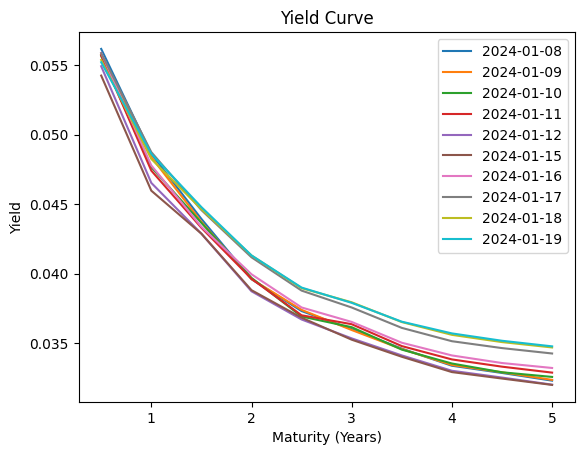

In [16]:
# Yield
fig=plt.figure()

for day in days:
    plt.plot(time_to_maturity, ytm_series[day].values(), label = day)

plt.title("Yield Curve")
plt.xlabel("Maturity (Years)")
plt.ylabel("Yield")
plt.legend()
plt.show()
fig.savefig('yield curve.jpg')

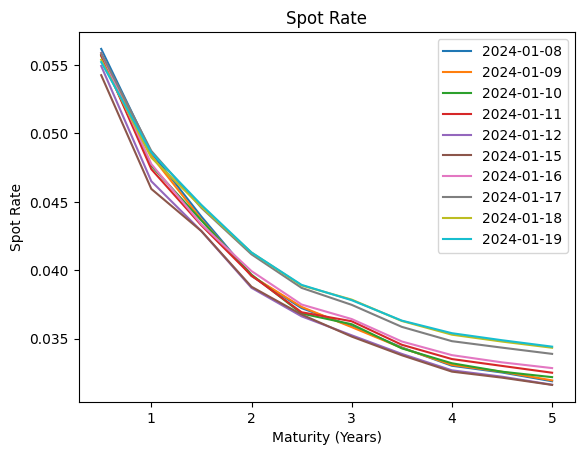

In [17]:
# Spot
fig=plt.figure()

for day in days:
    plt.plot(time_to_maturity, Spot_rate_series[day], label = day)

plt.title("Spot Rate")
plt.xlabel("Maturity (Years)")
plt.ylabel("Spot Rate")
plt.legend()
plt.show()
fig.savefig('spot rate.jpg')

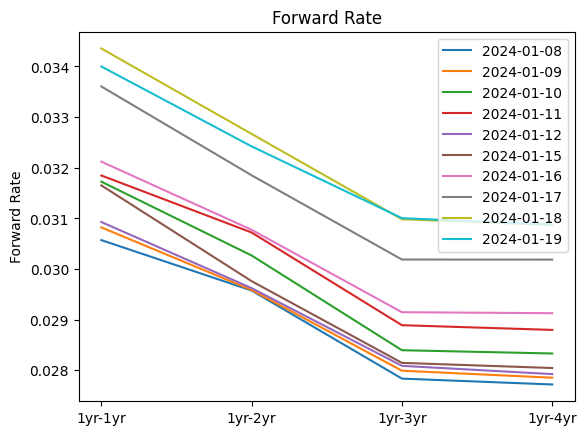

In [18]:
# Forward
fig=plt.figure()
forward_tenor = ['1yr-1yr', '1yr-2yr', '1yr-3yr', '1yr-4yr']
for day in days:
    plt.plot(tenor, forward_rate_series[day], label = day)

plt.title("Forward Rate")
plt.xticks(tenor, forward_tenor)
plt.ylabel("Forward Rate")
plt.legend()
plt.show()
fig.savefig('forward rate.jpg')

### Question 5

In [19]:
# Covariance

log_yield = np.zeros([5, 9])
log_forward = np.zeros([4, 9])

for i in range(4):
    for j in range(9):
        log_yield[i,j] = np.log(ytm_series[days[j+1]][bond_list[i]]/ytm_series[days[j]][bond_list[i]])


for i in range(4):
    for j in range(9):
        log_forward[i,j] = np.log(forward_rate_series[days[j+1]][i] / forward_rate_series[days[j]][i])

In [20]:
Cov_yield = np.cov((log_yield.T - np.mean(log_yield.T, axis = 0)).T)
Cov_forward = np.cov((log_forward.T - np.mean(log_forward.T, axis = 0)).T)

In [21]:
Cov_yield

array([[1.68673771e-04, 2.10593508e-04, 6.43832318e-05, 1.49972124e-04,
        0.00000000e+00],
       [2.10593508e-04, 3.54057697e-04, 1.58911148e-04, 2.59029764e-04,
        0.00000000e+00],
       [6.43832318e-05, 1.58911148e-04, 1.30458345e-04, 1.63569944e-04,
        0.00000000e+00],
       [1.49972124e-04, 2.59029764e-04, 1.63569944e-04, 2.62533761e-04,
        0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00]])

In [22]:
Cov_forward

array([[0.00048811, 0.00043609, 0.00034891, 0.00037244],
       [0.00043609, 0.00051906, 0.0004437 , 0.00046639],
       [0.00034891, 0.0004437 , 0.00039593, 0.00041149],
       [0.00037244, 0.00046639, 0.00041149, 0.00043243]])

In [23]:
eigenvalue_yield, eigenvector_yield = eig(Cov_yield)
eigenvalue_forward, eigenvector_forward = eig(Cov_forward)

In [24]:
print(eigenvalue_yield)
print(eigenvector_yield)
print(eigenvalue_yield.real[0])
print(eigenvector_yield[:,0])

[7.80273768e-04 1.01213675e-04 5.38867725e-06 2.88474530e-05
 0.00000000e+00]
[[ 0.3955071   0.62814031  0.51694884  0.42635404  0.        ]
 [ 0.65470173  0.27093114 -0.30545974 -0.63612602  0.        ]
 [ 0.33741453 -0.60889965  0.67751903 -0.23740389  0.        ]
 [ 0.54871779 -0.40159342 -0.42476605  0.59766656  0.        ]
 [ 0.          0.          0.          0.          1.        ]]
0.0007802737682712104
[0.3955071  0.65470173 0.33741453 0.54871779 0.        ]


In [25]:
print(eigenvalue_forward)
print(eigenvector_forward)
print(eigenvalue_forward.real[0])
print(eigenvector_forward[:,0])

[1.70439766e-03 1.22953159e-04 6.12432405e-06 2.05520646e-06]
[[-0.48303005 -0.85671829 -0.18067342 -0.00853539]
 [-0.548411    0.13762598  0.81841955 -0.10243978]
 [-0.47033901  0.36861563 -0.45940815 -0.65715133]
 [-0.49468027  0.33348968 -0.29409302  0.74671639]]
0.0017043976643929969
[-0.48303005 -0.548411   -0.47033901 -0.49468027]
